<a href="https://www.kaggle.com/code/rama3282/mnist-using-simpleann-baseline-pytorch?scriptVersionId=99940285" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# MNIST using simple ANN baseline model

In this notebook , we are going to go through the details on how to build a simple deep learning model (ANN) to predict the labels of handwritten digits given it's image . We would be using MNIST dataset from Kaggle for training the model ([link](https://www.kaggle.com/competitions/digit-recognizer)) .I'll try my best to keep things as simple as possible here and explain the steps and the process we follow as we go through this notebook . 
The first step is to inspect the dataset, the format in which the images are stored and the correspoinding labels assciated with the same .  

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


We notice that the data is stored in the form of csv . We can quickly use pandas to read the CSVs in the form of dataframe and go though it's contents . We read through both the train and test files to see the columns in each of them and that'll give us an idea on what the target variable is . 

In [2]:
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
print(train_df.shape , test_df.shape)
print("Train Cols : " , train_df.columns)
print("Test Cols : " , test_df.columns)
print(" Label -  " , [i for i in train_df.columns if i not in test_df.columns] )

(42000, 785) (28000, 784)
Train Cols :  Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)
Test Cols :  Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)
 Label -   ['label']


There are 42K Rows in the training dataset and 28K in the test_dataset . From the column names , we conculde that the pictures are stored in the form of rows where the column - <b> pixel_1 </b> indicates the pixel density value in the <b> cell_no[1] </b> in the image  . Since there are values till pixel_783 , there are 784 pixel counts which means it's a 28*28 image . To find the target column , we simply check for columns in the training dataset that is not a part of test dataset

## Creating the dataset class for the pytorch model

We are going to follow best practices of pytorch get the data in the form of <b>Dataset</b> since it makes life easier for us to create the dataloaders which would later be used in the training processes . Here we create our own custom class inheriting the <b> Dataset </b> class specifying how to access the elements of the dataset undet the __getitem__ method . Under this method , we read the data and store it under __img_df__ and extract the image , convert them into 28*28 numpy array  , bring the values under the range [0,1] and perform transforms on both the image and the label seperately and returns them in the form of X , y tensors . This custom class accepts the following arguments
* csv_name - The name under which the data is stored 
* img_dir - the path of the directory under which the file is stored.
* transform - The tranforms that needs to be done on the image vector 
* target_transform - The transforms that needs to be done on the target variable

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor , Lambda

class CustomMNISTDataset(Dataset):
    def __init__(self, csv_name, img_dir, transform=None, target_transform=None , label_name = "label"):
        
        self.img_filename = csv_name
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.label_name = label_name
        
        img_path = os.path.join(self.img_dir, self.img_filename)
        self.img_df = pd.read_csv(img_path)

    def __len__(self):
        return len(self.img_df)

    def __getitem__(self, idx):
        
        # Extracting all the other columns except label_name
        img_cols = [ i for i in self.img_df.columns if i not in self.label_name]
        
        image = self.img_df.iloc[[idx]][img_cols].values

        # Reshaping the array from 1*784 to 28*28
        image = image.reshape(28,28)
        # image = image.astype(float)

        # Scaling the image so that the values only range between 0 and 1
        image = image/255.0
        
        
        if self.transform:
            image = self.transform(image)
    
        image = image.to(torch.float)    
        
        if self.label_name in self.img_df.columns:
            
            if self.target_transform:
                label = self.target_transform(label)
            label = int(self.img_df.iloc[[idx]][self.label_name].values)
            return image, label
        
        # Exceptions for test where labels are absent
        else :
            return image
        
        

### Distribution of target labels

Before actually creating the datasets , we just peek into the training dataset just to see how many target variables are actually present in the dataset . This will give us a sense of whether the dataset is skewed towards a particular label compared to others

In [4]:
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
train_df['label'].value_counts().sort_index()

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

We see that the distribution of the labels are fairly equal and is not highly skewed towards any particular varibale here.

### Distribution of labels in both train and valid sets

To measure at the actual model performance , it is required to create train and valid subsets from our training_data set . We will only use the train_subset for training the model and will check the performance of the same with the valid dataset . For creating the valid dataset , we will stratify using the y-labels just to ensure that the distribution of both the train and valid subsets remain the same

In [5]:
## Illustration of creating a validation set 

from sklearn.model_selection import train_test_split
indices = list(range(len(train_df)))

train_indices , test_indices = train_test_split(indices, test_size=0.1, stratify=train_df['label'])
# train_indices , test_indices = train_test_split(indices, test_size=0.1)

len(train_indices) , len(test_indices) , len(train_df)

train_subset = train_df.loc[train_indices]
val_subset = train_df.loc[test_indices]

print("Distribution of target values in training dataset ; ")
print( train_subset['label'].value_counts().sort_index() / train_subset['label'].value_counts().sort_index().sum() )

print("Distribution of target values in validation dataset ; ")
print( val_subset['label'].value_counts().sort_index() / val_subset['label'].value_counts().sort_index().sum() )

Distribution of target values in training dataset ; 
0    0.098386
1    0.111534
2    0.099444
3    0.103598
4    0.096958
5    0.090344
6    0.098492
7    0.104788
8    0.096746
9    0.099709
Name: label, dtype: float64
Distribution of target values in validation dataset ; 
0    0.098333
1    0.111429
2    0.099524
3    0.103571
4    0.096905
5    0.090476
6    0.098571
7    0.104762
8    0.096667
9    0.099762
Name: label, dtype: float64


## Creating Train Dataset using train data

We will go ahead and create the train_dataset using the class we have defined above . As for the arguments , we supply the directory and the csv_name based on the values provided below . For transforms , we use the function ToTensor() which converts the numpy aray to tensor and Normalize(mean , std) helping us normalize the dataset with the given mean and standard deviation so that the values are not out pf proportion . We keep the target_transform value as None since nothing needs to be done on the target variable

In [6]:
from torchvision import transforms

# Crerating a temp dataset
train_csv_name = "train.csv"
test_csv_name = "test.csv"
img_dir = "/kaggle/input/digit-recognizer/"

# Converting X variables to Tensors
transforms = transforms.Compose( [transforms.ToTensor() , transforms.Normalize((0.5,), (0.5,)) , ] )

# Converting y-labels to one hot encoding
# target_transform = Lambda(lambda y: torch.zeros(
#     len(train_df['label'].unique()), dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
# This is not need since we are going to be using cross entropy loss function

label_name = "label"

train_dataset = CustomMNISTDataset(csv_name = train_csv_name , img_dir = img_dir , transform = transforms , target_transform = None , label_name = label_name)

# Inspecting the fist line item under dataset
x0 , y0 = train_dataset[0]
print(x0.shape , y0)

torch.Size([1, 28, 28]) 1


### Plotting the datapoints of train_dataset

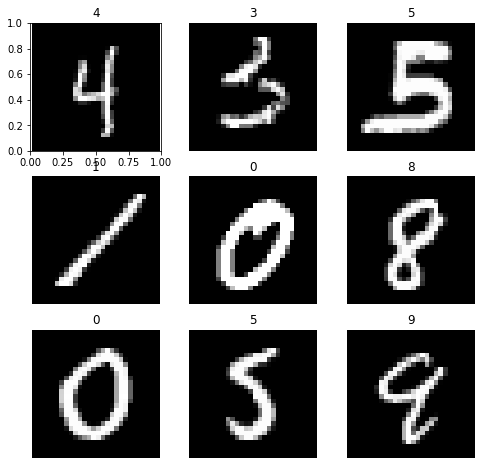

In [7]:
# Ploting some of the datapoints in the dataset
import matplotlib.pyplot as plt

# sample_img , sample_lbl = temp_train_dataset[3]
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
figure.add_subplot(rows, cols, 1)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    sample_img , sample_lbl = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(sample_lbl)
    plt.axis("off")
    plt.imshow(sample_img.squeeze(), cmap="gray")
plt.show()

Checking if the device has GPU present , if not we do the whole training process on CPU (The downside being it can be very slow)

In [8]:
## Checking if the GPU is being used properly . 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.cuda.is_available()
x0 = x0.to(device)
print("x0" , x0.is_cuda)

Using device: cpu
x0 False


## Creating test and valid subsets using stratified samples

We then proceed on splitting the training_dataset into train and valid subsets as defined above using stratified sampling . We keep the valid set as 10% of the training_dataset .Notice that when we look at the contents of train_dataloaders , the dimension is (torch.Size([64, 1, 28, 28]), torch.Size([64])) which is differnt from the contents of train_dataset torch.Size([1, 28, 28]), int). This is essentially a batch that gets processed at the time of training .

In [9]:
from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import train_test_split
indices = list(range(len(train_df)))
train_indices , valid_indices = train_test_split(indices, test_size=0.1, stratify=train_df['label'])

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(test_indices)

train_dataloader = torch.utils.data.DataLoader(train_dataset , batch_size=64, sampler=train_sampler, num_workers=16)
valid_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=valid_sampler, num_workers=16)

x0 , y0 = next(iter(train_dataloader))
x0.shape , y0.shape

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(torch.Size([64, 1, 28, 28]), torch.Size([64]))

## Defining NN Model 

Now that we are finished with defining the dataloaders , we then proceed to defining the details of the Neural Netowrk are going to be using for predictions. We use an architecture with 2 hidden layers and with the output layer having 10 Nodes (since there are 10 differnt classes for prediciton) . We define our our class inheriting the nn.Module to define our own forward propagation function since it's considered as best practice while working on pytorch .

The model would look as follows :

* We flatten our 28*28 image into a tensor of length 784 (which is achieved through nn.Flatten)
* We then input these into a hidden layer containing 128 nodes which is then connected to another hidden layer with 64 nodes. We use Relu as activation function inbetween layers 
* Finally we then connect the hidden layer with a layer having 10 nodes (Equivalent to the number of labels) 

<p> Notice that there's no softmax layer at the end of the NN . This is because the <b> nn.CrossEntropyLoss() </b> automatically applies softmax from the output obtained to calculate loss . However , if we use <b> nn.NLLLLoss() </b> as our loss fucntion , then we would have to include <b> nn.LogSoftmax </b> at the end of nn.Sequential(..) </p>

In [10]:
from torch import nn

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class MyOwnNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyOwnNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
            ## Softmax layer ignored since the loss function defined is nn.CrossEntropy()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return  logits
    
    
model = MyOwnNeuralNetwork().to(device)
print(model)

# model = model.cuda()
# torch.backends.cudnn.benchmark=True
# torch.cuda.set_device(0)

Using cpu device
MyOwnNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


## Defining Optimizers and loss function

We will use cross entrpy loss as loss function and stocastic gradient descent as optimizer for this particular exercise with learning rate as 0.003 and momentum as 0.9.

In [11]:
## Defining optimizer and loss functions 

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=3e-3, momentum=0.9)

## Defining Train loop

Under the training loop , we do the following things . 

* Place the model under train mode 
* enumerate the contents of dataloader which gives us X,y in the form batches
* For every batch 
    1. We use model to make predictions of X
    2. Compute the loss using the predicted and actual values of y
    3. Reset the gradient values to 0 .
    4. Perform back propagation 
    5. Update the parameters using the computed gradients from backpropagation . 
    6. Compute the training accuracy and loss using the predicted and actual y . 

In [12]:
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
def train(dataloader, model, loss_fn, optimizer):
    
    # Total size of dataset for reference
    size = 0
    
    # places your model into training mode
    model.train()
    
    # loss batch
    batch_loss = {}
    batch_accuracy = {}
    
    correct = 0
    _correct = 0
    
    
    
    # Gives X , y for each batch
    for batch, (X, y) in enumerate(dataloader):
        
        # Converting device to cuda
        X, y = X.to(device), y.to(device)
        model.to(device)
        
        # Compute prediction error / loss
        # 1. Compute y_pred 
        # 2. Compute loss between y and y_pred using selectd loss function
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # Backpropagation on optimizing for loss
        # 1. Sets gradients as 0 
        # 2. Compute the gradients using back_prop
        # 3. update the parameters using the gradients from step 2
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _correct = (y_pred.argmax(1) == y).type(torch.float).sum().item()
        _batch_size = len(X)
        
        correct += _correct
        
        # Updating loss_batch and batch_accuracy
        batch_loss[batch] = loss.item()
        batch_accuracy[batch] = _correct/_batch_size
        
        size += _batch_size
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}]")
    
    correct/=size
    print(f"Train Accuracy: {(100*correct):>0.1f}%")
    
    return batch_loss , batch_accuracy

## Defining valid/test loop

Validation loop is same as train loop ignoring the updates from backpropagation . Hence we need to set the model under evaluation mode to avoid any parameters update . We then calculate the loss and accuracy in the same way we did inside the training loop

In [13]:
def validation(dataloader, model, loss_fn):
    
    # Total size of dataset for reference
    size = 0
    num_batches = len(dataloader)
    
    # Setting the model under evaluation mode.
    model.eval()

    test_loss, correct = 0, 0
    
    _correct = 0
    _batch_size = 0
    
    batch_loss = {}
    batch_accuracy = {}
    
    with torch.no_grad():
        
        # Gives X , y for each batch
        for batch , (X, y) in enumerate(dataloader):
            
            X, y = X.to(device), y.to(device)
            model.to(device)
            pred = model(X)
            
            batch_loss[batch] = loss_fn(pred, y).item()
            test_loss += batch_loss[batch]
            _batch_size = len(X)
            
            _correct = (pred.argmax(1) == y).type(torch.float).sum().item()
            correct += _correct
            
            size+=_batch_size
            batch_accuracy[batch] = _correct/_batch_size
            
            
            
    
    ## Calculating loss based on loss function defined
    test_loss /= num_batches
    
    ## Calculating Accuracy based on how many y match with y_pred
    correct /= size
    
    print(f"Valid Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return batch_loss , batch_accuracy

## Training and validation triggers 

This step is mainly for defining the epochs (The number of passes that needs to be done on the entire dataset) while measuring the model performance . We also use a graph to measure the model loss for both train and test.

In [14]:
train_batch_loss = []
train_batch_accuracy = []
valid_batch_accuracy = []
valid_batch_loss = []
train_epoch_no = []
valid_epoch_no = []

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    _train_batch_loss , _train_batch_accuracy = train(train_dataloader, model, loss_fn, optimizer)
    _valid_batch_loss , _valid_batch_accuracy = validation(valid_dataloader, model, loss_fn)
    for i in range(len(_train_batch_loss)):
        train_batch_loss.append(_train_batch_loss[i])
        train_batch_accuracy.append(_train_batch_accuracy[i])
        train_epoch_no.append( t + float((i+1)/len(_train_batch_loss)))     
    for i in range(len(_valid_batch_loss)):
        valid_batch_loss.append(_valid_batch_loss[i])
        valid_batch_accuracy.append(_valid_batch_accuracy[i])
        valid_epoch_no.append( t + float((i+1)/len(_valid_batch_loss)))     
print("Done!")

Epoch 1
-------------------------------


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


loss: 2.319053  [    0]
loss: 1.471163  [ 6400]
loss: 0.675529  [12800]
loss: 0.590934  [19200]
loss: 0.417268  [25600]
loss: 0.295707  [32000]
Train Accuracy: 78.2%
Valid Error: 
 Accuracy: 89.1%, Avg loss: 0.360749 

Epoch 2
-------------------------------
loss: 0.281806  [    0]
loss: 0.343148  [ 6400]
loss: 0.358678  [12800]
loss: 0.313208  [19200]
loss: 0.232435  [25600]
loss: 0.229005  [32000]
Train Accuracy: 90.4%
Valid Error: 
 Accuracy: 91.8%, Avg loss: 0.269360 

Epoch 3
-------------------------------
loss: 0.225520  [    0]
loss: 0.309443  [ 6400]
loss: 0.107599  [12800]
loss: 0.335566  [19200]
loss: 0.262280  [25600]
loss: 0.398198  [32000]
Train Accuracy: 92.0%
Valid Error: 
 Accuracy: 92.6%, Avg loss: 0.237691 

Epoch 4
-------------------------------
loss: 0.217512  [    0]
loss: 0.286153  [ 6400]
loss: 0.261390  [12800]
loss: 0.193834  [19200]
loss: 0.286631  [25600]
loss: 0.260825  [32000]
Train Accuracy: 93.1%
Valid Error: 
 Accuracy: 93.9%, Avg loss: 0.194569 

Epoc

We see decent validation accuracy of above 95% with just using a Neural Network of 2 hidden layers with 128 and 64 units . To further increase the accuracy of the model , a convolution Neural Network can be used since it performs much better when it comes to image datasets . 

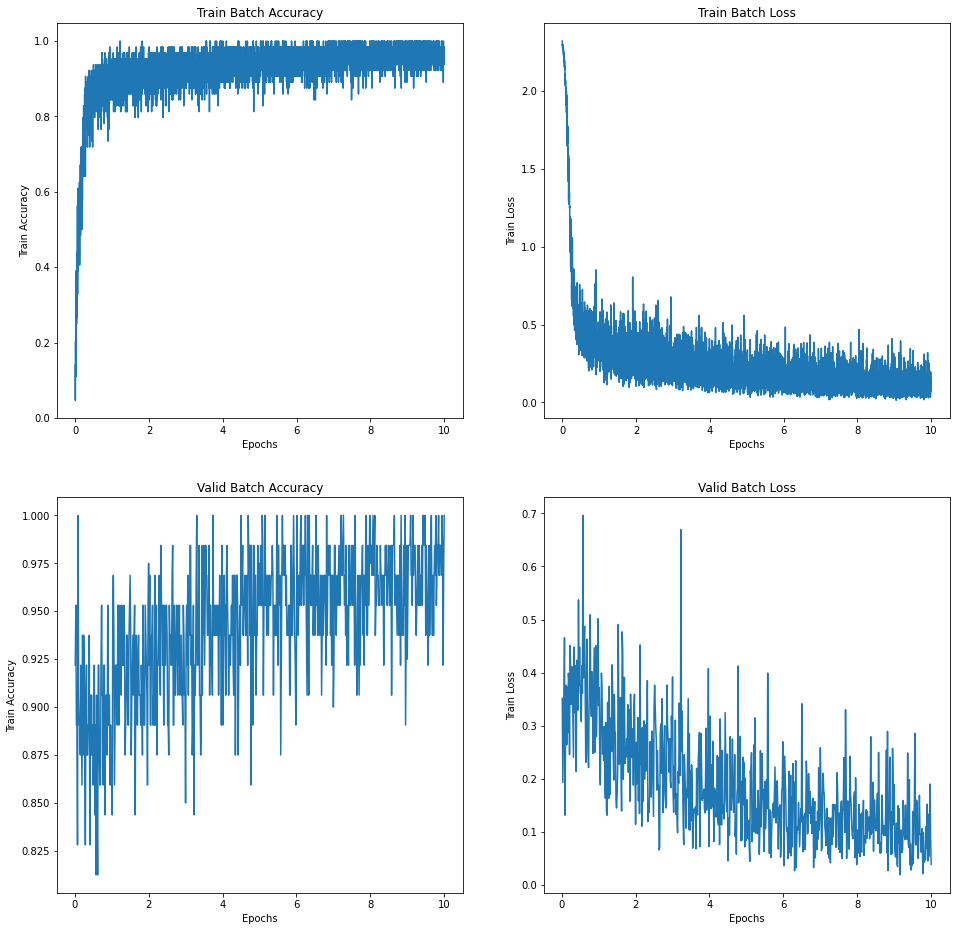

In [15]:
figure = plt.figure(figsize=(16, 16))


figure.add_subplot(2, 2, 1)
plt.plot(train_epoch_no , train_batch_accuracy)
plt.title("Train Batch Accuracy")
plt.xlabel("Epochs") 
plt.ylabel("Train Accuracy") 

figure.add_subplot(2, 2, 2)
plt.plot(train_epoch_no , train_batch_loss)
plt.title("Train Batch Loss")
plt.xlabel("Epochs") 
plt.ylabel("Train Loss") 

figure.add_subplot(2, 2, 3)
plt.plot(valid_epoch_no , valid_batch_accuracy)
plt.title("Valid Batch Accuracy")
plt.xlabel("Epochs") 
plt.ylabel("Train Accuracy") 

figure.add_subplot(2, 2, 4)
plt.plot(valid_epoch_no , valid_batch_loss)
plt.title("Valid Batch Loss")
plt.xlabel("Epochs") 
plt.ylabel("Train Loss") 


plt.show()



We can clearly see from the graphs that both the train and validation accuracy kept increasing with the number of epochs while train and valid loss kept decreasing which is the expected behaviour of gradient descent ! 

## Loading the test data for predictions

In [16]:
from torchvision import transforms

test_csv_name = "test.csv"
img_dir = "/kaggle/input/digit-recognizer/"

# Converting X variables to Tensors
transforms = transforms.Compose( [transforms.ToTensor() , transforms.Normalize((0.5,), (0.5,)) , ] )
label_name = "label"

test_dataset = CustomMNISTDataset(csv_name = test_csv_name , img_dir = img_dir , transform = transforms , target_transform = None , label_name = label_name)


## Making Predicitons on test data and saving them

In [17]:
probas = []
predictions = []
for i in range(len(test_dataset)):
    _probas = model(test_dataset[i])
    probas.append(_probas)
    predictions.append(_probas.argmax(1).item())

In [18]:
pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


In [19]:
# Saving the dataframe for submission
df = pd.DataFrame({'ImageId':range(1,len(predictions)+1),'Label':predictions})
df.to_csv("submission.csv",index=False)